In [1]:
from Neuron_analysis_tool.Analyzer import Analyzer, long_pulse_protocol
from neuron import gui, h
import numpy as np
import os
import matplotlib.pyplot as plt

NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


## Loading rall model

In [2]:
analyser = Analyzer(type='L5PC')

## plot the cell morphology

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 36897.83it/s]


<AxesSubplot:>

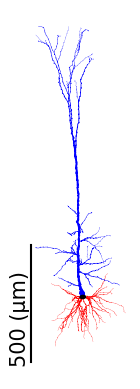

In [3]:
analyser.plot_morph(scale=500, diam_factor=0.5, theta=-90, ignore_soma=True)

## create a somaticentric view card 

optimizing lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 109188.95it/s]


(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}, xlabel='distance from origin (x / λ)', ylabel='V(x)/V(0)'>,
        <AxesSubplot:title={'center':'short pulse attanuation'}, xlabel='distance from origin (x / λ)'>],
       dtype=object))

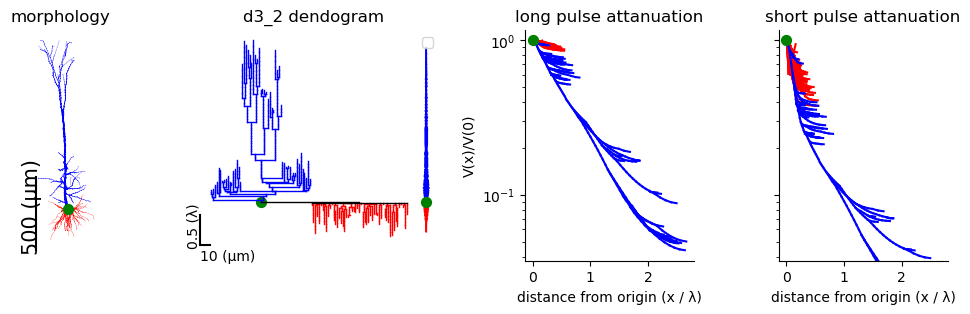

In [5]:
analyser.create_card(theta=-90, diam_factor=0.5)

## create a spasific segment centric view card

optimizing lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 101592.14it/s]


(<Figure size 1200x300 with 4 Axes>,
 array([<AxesSubplot:title={'center':'morphology'}>,
        <AxesSubplot:title={'center':'d3_2 dendogram'}>,
        <AxesSubplot:title={'center':'long pulse attanuation'}, xlabel='distance from origin (x / λ)', ylabel='V(x)/V(0)'>,
        <AxesSubplot:title={'center':'short pulse attanuation'}, xlabel='distance from origin (x / λ)'>],
       dtype=object))

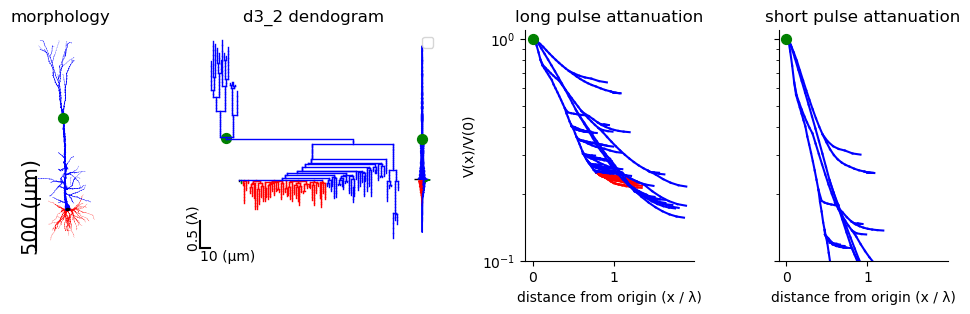

In [6]:
analyser.create_card(start_seg=list(analyser.cell.apic[50])[-1], theta=-90, diam_factor=0.5)

## defining a new protocol to record, protocol is a function that gets the cell and the start segment (in the case you intrested of using a spasific one), and runs a simulation.
### the function muyst return the tstop of the simulation, the delay/time to start, the duration of the activation, the amplitude, and a dictionary with extra stuff you want to save for to the end of the computation of this video

In [18]:
def Ca_spike_protocol(cell, start_seg):
    delay=400.0
    stim = h.IClamp(0.5, sec=cell.soma[0])
    stim.dur   = 5
    stim.delay = delay

    syn = h.epsp(cell.apic[36](0.9))
    syn.tau0  = 0.5
    syn.tau1 = 5
    syn.onset   = stim.delay + 5
    syn.imax = 0.5 
    stim.amp = 1.9
    
    h.tstop = 700
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    h.run()
    return h.tstop, 400, 1400, 0, {}

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 98007.10it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


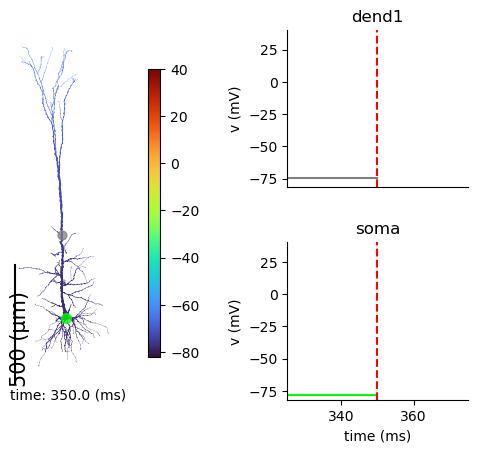

In [21]:
show_records_from = dict()
show_records_from[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
show_records_from[list(analyser.cell.apic[36])[0]] = dict(label='dend1', alpha=0.75, color='grey', size=40)

record_dict = analyser.record_protocol(protocol=Ca_spike_protocol, cut_start_ms=None, record_name='v')
animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=0.5, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict())
animation.ipython_display(fps=10, loop=True, autoplay=True)

### you can also create a movie af spasific channel conductance

In [22]:
# get all the mechanisem name in the model
analyser.get_mechanism_names()

['Ca_LVAst',
 'Nap_Et2',
 'CaDynamics_E2',
 'na_ion',
 'Im',
 'Ca_HVA',
 'k_ion',
 'pas',
 'K_Tst',
 'Ih',
 'K_Pst',
 'ca_ion',
 'SK_E2',
 'NaTa_t',
 'SKv3_1']

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 16147.78it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


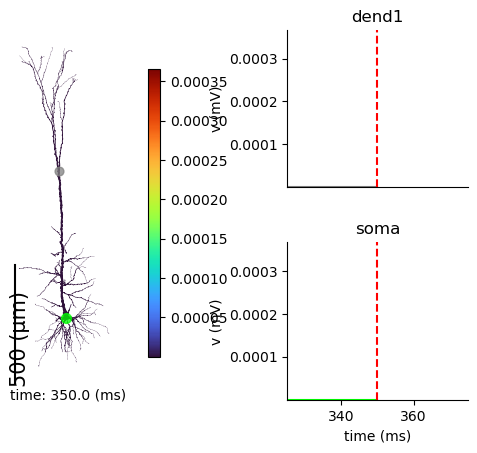

In [23]:
show_records_from = dict()
show_records_from[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
show_records_from[list(analyser.cell.apic[50])[-1]] = dict(label='dend1', alpha=0.75, color='grey', size=40)
record_dict = analyser.record_protocol(protocol=Ca_spike_protocol, cut_start_ms=None, record_name='gCa_LVAst_Ca_LVAst')
animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=0.5, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict())
animation.ipython_display(fps=10, loop=True, autoplay=True)

### adding a protocol of random synapses

In [8]:
def add_syn(seg, g_AMPA=0.0004, g_NMDA=0.0004):
    netstim = h.NetStim()
    netstim.interval = 400 # fr of 1
    netstim.start = 400
    netstim.noise = 0.3
    netstim.number = 1e9
    # AMPA part
    AMPA = h.Exp2Syn(seg.x, sec=seg.sec)
    AMPA_con= h.NetCon(netstim, AMPA)
    AMPA.e = 0
    AMPA.tau1 = 0.3
    AMPA.tau2 = 1.5
    AMPA_con.weight[0] = g_AMPA
    AMPA_con.delay = 0

    # NMDA part
    NMDA=h.NMDA(seg.x, sec=seg.sec)
    NMDA_con = h.NetCon(netstim, NMDA)
    NMDA.e = 0
    NMDA.tau_r_NMDA = 8
    NMDA.tau_d_NMDA = 35
    NMDA.n_NMDA = 0.27
    NMDA.gama_NMDA = 0.076
    NMDA_con.weight[0] = g_NMDA
    NMDA_con.delay = 0
    return [AMPA, AMPA_con], [NMDA, NMDA_con], netstim

def add_isyn(seg, g_GABA=0.0004):
    netstim = h.NetStim()
    netstim.interval = 500 # fr of 1
    netstim.start = 400
    netstim.noise = 1.0
    netstim.number = 1e9
    # AMPA part
    AMPA = h.Exp2Syn(seg.x, sec=seg.sec)
    AMPA_con= h.NetCon(netstim, AMPA)
    AMPA.e = -100
    AMPA.tau1 = 0.2
    AMPA.tau2 = 4
    AMPA_con.weight[0] = g_GABA
    AMPA_con.delay = 0

    return [AMPA, AMPA_con], netstim


def random_syn_protocol(cell, start_seg):
    syns = []
    isyns = []
    segs_e = []
    segs_i = []
    
    for sec in np.random.choice(list(cell.all), 5000):
        x = np.random.rand()
        seg_num = np.random.randint(0, len(list(sec)))
        segs_e.append(list(sec)[seg_num])
        syns.append(add_syn(list(sec)[seg_num]))
    for sec in np.random.choice(list(cell.all), 1000):
        seg_num = np.random.randint(0, len(list(sec)))
        segs_i.append(list(sec)[seg_num])
        syns.append(add_isyn(list(sec)[seg_num]))
#         x = np.random.rand()
#         isyns.append(add_isyn(sec(x)))
    h.tstop = 1400
    h.v_init = cell.soma[0].e_pas
    h.celsius = 37
    h.run()
    return h.tstop, 400, 1400, 0, {}

optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 46445.40it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


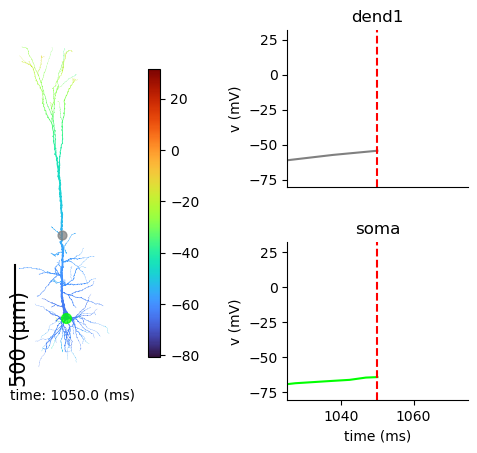

In [4]:
show_records_from = dict()
show_records_from[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
show_records_from[list(analyser.cell.apic[36])[0]] = dict(label='dend1', alpha=0.75, color='grey', size=40)

record_dict = analyser.record_protocol(protocol=random_syn_protocol, cut_start_ms=None, record_name='v')
animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=0.5, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict())
animation.ipython_display(fps=10, loop=True, autoplay=True)


optimizing lines: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 94049.15it/s]


Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


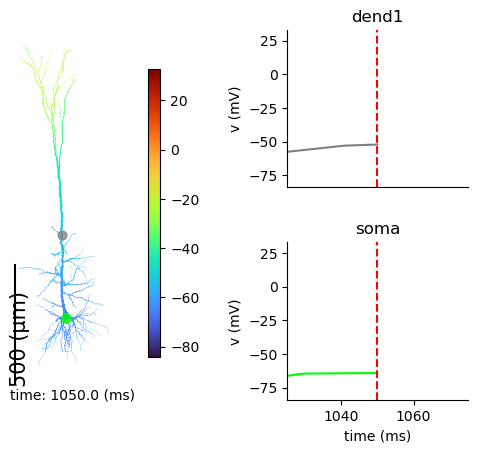

In [9]:
show_records_from = dict()
show_records_from[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
show_records_from[list(analyser.cell.apic[36])[0]] = dict(label='dend1', alpha=0.75, color='grey', size=40)

record_dict = analyser.record_protocol(protocol=random_syn_protocol, cut_start_ms=None, record_name='v')
animation = analyser.create_movie_from_rec(records=record_dict, slow_down_factor=50, 
                                           func_for_missing_frames=np.max, theta=-90, diam_factor=0.5, 
                                           show_records_from=show_records_from, seg_to_indicate_dict=dict())
animation.ipython_display(fps=10, loop=True, autoplay=True)
